In [0]:
from fastai import *
from fastai.tabular import *
import pandas as pd
from torchsummary import summary
import torch
from torch import nn
import imageio
import torch
import glob
from fastai.vision import *
import os
from torch import nn
import torch.nn.functional as F

In [2]:
colab = True
if colab:
  from google.colab import drive
  drive.mount('/content/drive', force_remount = True)
  %cp "/content/drive/My Drive/autoencoder-training/data.zip" .
  !unzip -q data.zip
  image_path = "data"
else: 
  os.chdir("../")
  image_path = os.getcwd() + "/data"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Data

In [0]:
np.random.seed(3333)
torch.manual_seed(3333)

size = 32
def get_data(size=32):
  batchsize = 128
  tfms = get_transforms(do_flip = True)
  src = (ImageImageList.from_folder(image_path).use_partial_data(0.1).split_by_folder().label_from_func(lambda x: x))
  data = (src.transform(tfms, size=size, tfm_y=True)
          .databunch(bs=batchsize)
          .normalize(imagenet_stats, do_y = False))
  return data

In [0]:
data = get_data()

# Model

In [0]:
def icnr(x, scale=2, init=nn.init.kaiming_normal_):
    "ICNR init of `x`, with `scale` and `init` function."
    ni,nf,h,w = x.shape
    ni2 = int(ni/(scale**2))
    k = init(torch.zeros([ni2,nf,h,w])).transpose(0, 1)
    k = k.contiguous().view(ni2, nf, -1)
    k = k.repeat(1, 1, scale**2)
    k = k.contiguous().view([nf,ni,h,w]).transpose(0, 1)
    x.data.copy_(k)

class PixelShuffle_ICNR(nn.Module):
    "Upsample by `scale` from `ni` filters to `nf` (default `ni`), using `nn.PixelShuffle`, `icnr` init, and `weight_norm`."
    def __init__(self, ni:int, nf:int=None, scale:int=2, blur:bool=False, norm_type=NormType.Weight, leaky:float=None):
        super().__init__()
        nf = ifnone(nf, ni)
        self.conv = conv_layer(ni, nf*(scale**2), ks=1, norm_type=norm_type, use_activ=False)
        icnr(self.conv[0].weight)
        self.shuf = nn.PixelShuffle(scale)
        # Blurring over (h*w) kernel
        # "Super-Resolution using Convolutional Neural Networks without Any Checkerboard Artifacts"
        # - https://arxiv.org/abs/1806.02658
        self.pad = nn.ReplicationPad2d((1,0,1,0))
        self.blur = nn.AvgPool2d(2, stride=1)
        self.relu = relu(True, leaky=leaky)

    def forward(self,x):
        x = self.shuf(self.relu(self.conv(x)))
        return self.blur(self.pad(x)) if self.blur else x


In [0]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Input size: [batch, 3, 32, 32]
        # Output size: [batch, 3, 32, 32]
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1),            # [batch, 12, 16, 16]
            nn.BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=2, padding=1),           # [batch, 24, 8, 8]
            nn.BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.Conv2d(24, 48, 4, stride=2, padding=1),           # [batch, 48, 4, 4]
            nn.BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.Conv2d(48, 96, 4, stride=2, padding=1),           # [batch, 96, 2, 2]
            nn.BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.Conv2d(96, 192, 4, stride=2, padding=1),           # [batch, 192, 1, 1]
            nn.BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            PixelShuffle_ICNR(192, 96),
            nn.BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            PixelShuffle_ICNR(96, 48),
            nn.BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            PixelShuffle_ICNR(48, 24),
            nn.BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            PixelShuffle_ICNR(24, 12),
            nn.BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            PixelShuffle_ICNR(12, 3),
            nn.BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.Sigmoid(),
        )
        
    def encode(self, x): return self.encoder(x)
    
    def decode(self, x): return self.decoder(x)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Learner

In [0]:
autoencoder = Autoencoder()
learn = Learner(data, autoencoder, loss_func = F.mse_loss)

In [16]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,time
0,0.053779,0.050288,00:14
1,0.044674,0.039303,00:13
2,0.036617,0.034317,00:13
3,0.030285,0.027755,00:13
4,0.025733,0.023967,00:13
5,0.022537,0.021932,00:13
6,0.020391,0.020807,00:13
7,0.018956,0.019588,00:13
8,0.018003,0.019092,00:13
9,0.017539,0.019036,00:13


In [17]:
learn.lr_find()

epoch,train_loss,valid_loss,time
0,0.017068,#na#,00:12
1,0.020672,#na#,00:12


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 2.51E-05
Min loss divided by 10: 7.59E-08


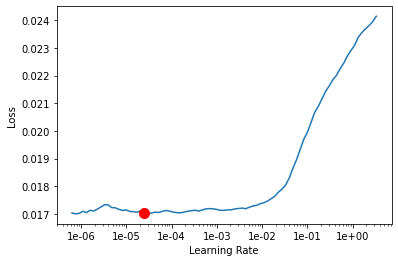

In [18]:
learn.recorder.plot(suggestion = True)

In [19]:
learn.fit_one_cycle(10, max_lr = 2.51E-05)

epoch,train_loss,valid_loss,time
0,0.017058,0.019030,00:13
1,0.017068,0.019037,00:13
2,0.017024,0.019008,00:13
3,0.016958,0.018919,00:13
4,0.016945,0.018931,00:14
5,0.017005,0.018873,00:14
6,0.016982,0.018858,00:14
7,0.016923,0.018914,00:14
8,0.016902,0.018866,00:14
9,0.016878,0.018836,00:14


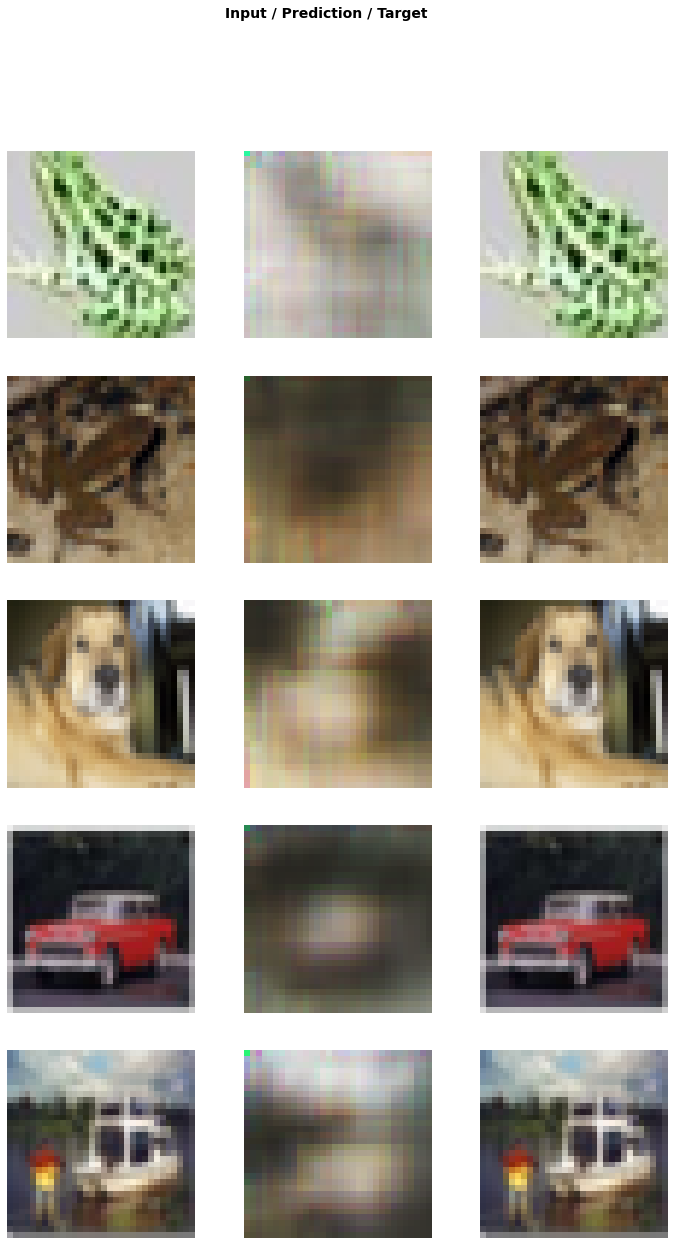

In [20]:
learn.show_results()

In [21]:
learn.fit_one_cycle(10, max_lr = 2.51E-06)

epoch,train_loss,valid_loss,time
0,0.016878,0.018832,00:13
1,0.016879,0.018834,00:14
2,0.016801,0.018849,00:14
3,0.016837,0.018839,00:14
4,0.016876,0.018842,00:13
5,0.016884,0.018842,00:13
6,0.016892,0.018851,00:13
7,0.016940,0.018835,00:14
8,0.016942,0.018818,00:13
9,0.016876,0.018816,00:13


# Resnet Not Pretrained

## Model

In [0]:
class Encoder1(nn.Module):
    def __init__(self):
        super(Encoder1, self).__init__()

        resnet = torch.hub.load('pytorch/vision:v0.5.0', 'resnet34', pretrained = False)
        resnet = nn.Sequential(*(list(resnet.children())[0:3]))
        for param in resnet.parameters():
            param.requires_grad = True

        self.encoder = nn.Sequential(resnet)

    def encode(self, x): return self.encoder(x)

    def forward(self, x):
      encoded = self.encoder(x)
      return encoded

class Encoder2(nn.Module):
    def __init__(self):
        super(Encoder2, self).__init__()

        resnet = torch.hub.load('pytorch/vision:v0.5.0', 'resnet34', pretrained = False)
        resnet = nn.Sequential(*(list(resnet.children())[3:5]))
        for param in resnet.parameters():
            param.requires_grad = True
        for i in range(len(resnet)):
            for param in resnet[1][i].bn1.parameters():
                param.requires_grad = True
            for param in resnet[1][i].bn2.parameters():
                param.requires_grad = True

        self.encoder = nn.Sequential(resnet)

    def encode(self, x): return self.encoder(x)

    def forward(self, x):
      encoded = self.encoder(x)
      return encoded

class Encoder3(nn.Module):
    def __init__(self):
        super(Encoder3, self).__init__()

        resnet = torch.hub.load('pytorch/vision:v0.5.0', 'resnet34', pretrained = False)
        resnet = nn.Sequential(*(list(resnet.children())[5]))
        for param in resnet.parameters():
            param.requires_grad = True
        for i in range(len(resnet)):
            for param in resnet[i].bn1.parameters():
                param.requires_grad = True
            if i== 0:
                for param in resnet[i].downsample[1].parameters():
                  param.requires_grad = True
            for param in resnet[i].bn2.parameters():
                param.requires_grad = True

        self.encoder = nn.Sequential(resnet)

    def encode(self, x): return self.encoder(x)

    def forward(self, x):
      encoded = self.encoder(x)
      return encoded

class Encoder4(nn.Module):
    def __init__(self):
        super(Encoder4, self).__init__()

        resnet = torch.hub.load('pytorch/vision:v0.5.0', 'resnet34', pretrained = False)
        resnet = nn.Sequential(*(list(resnet.children())[6]))
        for param in resnet.parameters():
            param.requires_grad = True
        for i in range(len(resnet)):
            for param in resnet[i].bn1.parameters():
                param.requires_grad = True
            if i== 0:
                for param in resnet[i].downsample[1].parameters():
                  param.requires_grad = True
            for param in resnet[i].bn2.parameters():
                param.requires_grad = True

        self.encoder = nn.Sequential(resnet)

    def encode(self, x): return self.encoder(x)

    def forward(self, x):
      encoded = self.encoder(x)
      return encoded

class Encoder5(nn.Module):
    def __init__(self):
        super(Encoder5, self).__init__()

        resnet = torch.hub.load('pytorch/vision:v0.5.0', 'resnet34', pretrained = False)
        resnet = nn.Sequential(*(list(resnet.children())[7]))
        for param in resnet.parameters():
            param.requires_grad = True
        for i in range(len(resnet)):
            for param in resnet[i].bn1.parameters():
                param.requires_grad = True
            if i== 0:
                for param in resnet[i].downsample[1].parameters():
                  param.requires_grad = True
            for param in resnet[i].bn2.parameters():
                param.requires_grad = True

        self.encoder = nn.Sequential(resnet)

    def encode(self, x): return self.encoder(x)

    def forward(self, x):
      encoded = self.encoder(x)
      return encoded

class AdaptiveConcatPool2d(Module):
    "Layer that concats `AdaptiveAvgPool2d` and `AdaptiveMaxPool2d`."
    def __init__(self, sz:Optional[int]=None):
        "Output will be 2*sz or 2 if sz is None"
        self.output_size = sz or 1
        self.ap = nn.AdaptiveAvgPool2d(self.output_size)
        self.mp = nn.AdaptiveMaxPool2d(self.output_size)

    def forward(self, x): return torch.cat([self.mp(x), self.ap(x)], 1)

class Encoder6(nn.Module):
    def __init__(self):
        super(Encoder6, self).__init__()

        self.encoder = nn.Sequential(AdaptiveConcatPool2d())

    def encode(self, x): return self.encoder(x)

    def forward(self, x):
      encoded = self.encoder(x)
      return encoded

class Decoder1(nn.Module):
    def __init__(self):
        super(Decoder1, self).__init__()

        self.decoder = nn.Sequential( 
            PixelShuffle_ICNR(64, 3),
            nn.BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
        )

    def decode(self,x): return self.decoder(x)

    def forward(self, x):
      decoded = self.decoder(x)
      return decoded

class Decoder2(nn.Module):
    def __init__(self):
        super(Decoder2, self).__init__()

        self.decoder = nn.Sequential( 
            PixelShuffle_ICNR(64, 64),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)
        )

    def decode(self,x): return self.decoder(x)

    def forward(self, x):
      decoded = self.decoder(x)
      return decoded

class Decoder3(nn.Module):
    def __init__(self):
        super(Decoder3, self).__init__()

        self.decoder = nn.Sequential( 
            PixelShuffle_ICNR(128, 64),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)
        )

    def decode(self,x): return self.decoder(x)

    def forward(self, x):
      decoded = self.decoder(x)
      return decoded

class Decoder4(nn.Module):
    def __init__(self):
        super(Decoder4, self).__init__()

        self.decoder = nn.Sequential( 
            PixelShuffle_ICNR(256, 128),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)
        )

    def decode(self,x): return self.decoder(x)

    def forward(self, x):
      decoded = self.decoder(x)
      return decoded

class Decoder5(nn.Module):
    def __init__(self):
        super(Decoder5, self).__init__()

        self.decoder = nn.Sequential( 
            PixelShuffle_ICNR(512, 256),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)
        )

    def decode(self,x): return self.decoder(x)

    def forward(self, x):
      decoded = self.decoder(x)
      return decoded


class Decoder6(nn.Module):
    def __init__(self):
        super(Decoder6, self).__init__()

        self.decoder = nn.Sequential( 
            nn.Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
        )

    def decode(self,x): return self.decoder(x)

    def forward(self, x):
      decoded = self.decoder(x)
      return decoded

class AutoEncoder2(nn.Module):
    def __init__(self):
        super(AutoEncoder2, self).__init__()

        self.encoder = nn.Sequential(Encoder1(), 
                                     Encoder2(), 
                                     Encoder3(), 
                                     Encoder4(), 
                                     Encoder5(), 
                                     Encoder6())

        self.decoder = nn.Sequential(Decoder6(),
                                     Decoder5(),
                                     Decoder4(),
                                     Decoder3(),
                                     Decoder2(),
                                     Decoder1())

    def encode(self, x): return self.encoder(x)

    def decode(self,x): return torch.clamp(self.decoder(x), min = 0, max=1)

      
    def forward(self, x):
      encoded = self.encoder(x)
      decoded = self.decoder(encoded)
      return torch.clamp(decoded, min = 0, max = 1)


## learn2

In [26]:
ae2 = AutoEncoder2()
learn2 = Learner(data, ae2, loss_func = F.mse_loss)

Downloading: "https://github.com/pytorch/vision/archive/v0.5.0.zip" to /root/.cache/torch/hub/v0.5.0.zip
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0


In [27]:
learn2.fit_one_cycle(10)

epoch,train_loss,valid_loss,time
0,0.195365,0.182923,00:16
1,0.133702,0.173757,00:15
2,0.100346,0.308150,00:15
3,0.078654,0.063596,00:15
4,0.066283,0.057023,00:15
5,0.055276,0.054987,00:16
6,0.047128,0.037399,00:15
7,0.041755,0.036733,00:16
8,0.038867,0.036296,00:16
9,0.037109,0.036421,00:15


In [28]:
learn2.lr_find()

epoch,train_loss,valid_loss,time
0,0.035244,#na#,00:15
1,0.043913,#na#,00:14


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.98E-06
Min loss divided by 10: 2.75E-05


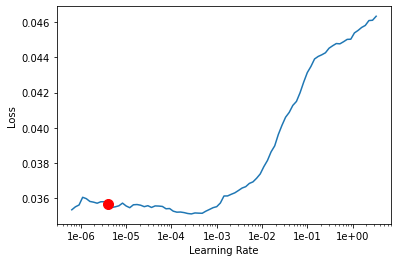

In [29]:
learn2.recorder.plot(suggestion = True)

In [30]:
learn2.fit_one_cycle(10, max_lr = 1e-04)

epoch,train_loss,valid_loss,time
0,0.035507,0.036054,00:15
1,0.035004,0.035454,00:15
2,0.034830,0.035875,00:15
3,0.034637,0.034687,00:15
4,0.034333,0.035425,00:15
5,0.033934,0.033628,00:15
6,0.033494,0.034274,00:15
7,0.033125,0.033418,00:15
8,0.033004,0.033733,00:15
9,0.032686,0.033319,00:15


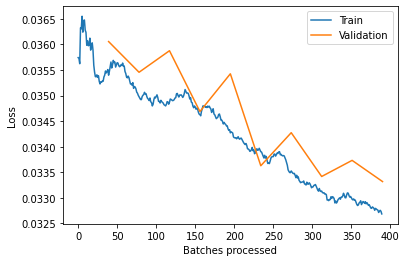

In [32]:
learn2.recorder.plot_losses()

In [33]:
learn2.fit_one_cycle(10, max_lr = 1e-05)

epoch,train_loss,valid_loss,time
0,0.032904,0.034049,00:15
1,0.032594,0.033450,00:15
2,0.032450,0.033423,00:15
3,0.032483,0.033361,00:15
4,0.032468,0.033553,00:16
5,0.032567,0.033404,00:16
6,0.032478,0.033222,00:15
7,0.032373,0.033146,00:15
8,0.032308,0.033183,00:15
9,0.032332,0.033910,00:15


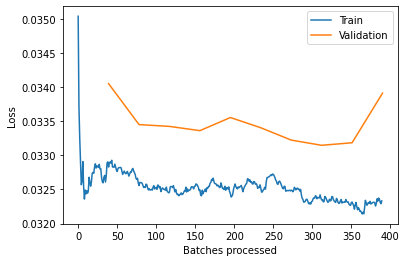

In [34]:
learn2.recorder.plot_losses()

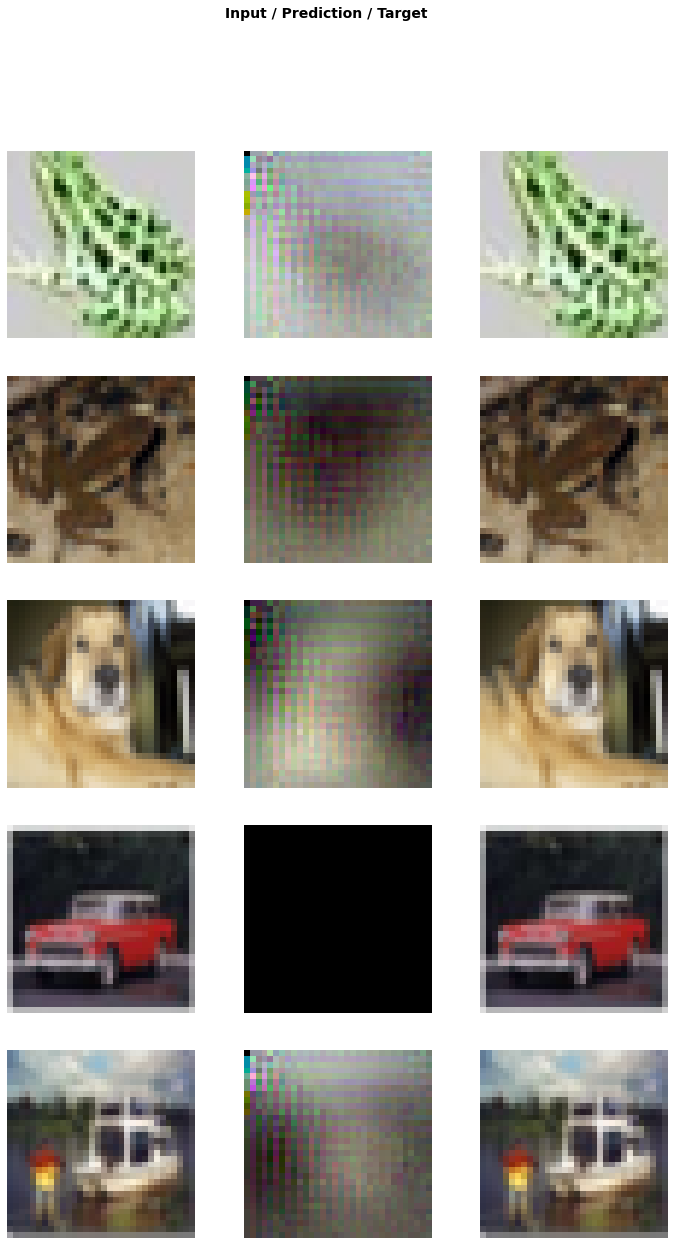

In [35]:
learn2.show_results()

In [0]:
tens = torch.randn([32,192, 1, 1])

In [8]:
tens.shape

torch.Size([32, 192, 1, 1])

In [10]:
tens.flatten(start_dim=1).shape

torch.Size([32, 192])

In [12]:
tens.squeeze().shape

torch.Size([32, 192])